### LSTM

LSTM networks, a type of RNN, excel at retaining sequential data over time, crucial for understanding financial markets. By integrating attention mechanisms, they can focus on relevant information, enhancing prediction accuracy. This combination offers a potent tool for deciphering complex market patterns and revolutionizing stock market analysis.

### Attention Mechanism

The attention mechanism works by allowing a model to selectively focus on certain parts of input data while ignoring others. It does this by assigning weights to different parts of the input sequence, indicating their importance. During processing, the model adjusts these weights dynamically based on the relevance of each part of the sequence to the task at hand.

  - Score Calculation
  s_i = calculate score for ith element

  - Attention Weights
  alpha_i = exp(s_i) / sum(exp(s_j) for j in range(n))

  - Context Vector
  context_vector = sum(alpha_i * h_i for i, h_i in enumerate(input_sequence))


In [31]:
!pip install tensorflow -qqq
!pip install keras -qqq
!pip install yfinance -qqq
!pip install mplfinance -qqq

In [32]:
import tensorflow as tf
import keras
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Check TensorFlow version
print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.15.0


### Data Download

In [33]:
# Fetch AAPL data
aapl_data = yf.download('AAPL', start='2020-01-01', end='2024-01-01')

# Display the first few rows of the dataframe
aapl_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,72.960449,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.251137,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.826851,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.484360,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.650352,132079200


### Data Preprocessing and Train Test Split

When working with data, you might find mistakes or anomalies, like unrealistic spikes in stock prices. These errors can happen due to problems during data collection. To fix this, find the mistakes, correct or remove them, and double-check the data to make sure it's accurate. This helps ensure your analysis is reliable and accurate.

In [34]:
# Checking for missing values
aapl_data.isnull().sum()

# Filling missing values, if any
aapl_data.fillna(method='ffill', inplace=True)

Applying Min-Max Scaling so the dataset scales the dataset in range of 0 and 1.

In [35]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
aapl_data_scaled = scaler.fit_transform(aapl_data['Close'].values.reshape(-1,1))

Choose a sequence length (like 60 days). This means, for every sample, the model will look at the last 60 days of data to make a prediction.

In [36]:
X = []
y = []

for i in range(60, len(aapl_data_scaled)):
    X.append(aapl_data_scaled[i-60:i, 0])
    y.append(aapl_data_scaled[i, 0])

Typically, 80% of data is used for training and 20% for testing.

In [37]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [38]:
X_train, y_train = np.array(X_train), np.array(y_train)

Finally, we need to reshape our data into a 3D format **[samples, time steps, features]** required by LSTM layers.

In [39]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [40]:
X_train.shape,y_train.shape

((756, 60, 1), (756,))

### Building the LSTM with Attention Model

  - In this model, units represent the number of neurons in each LSTM layer. return_sequences=True is crucial in the first layers to ensure the output includes sequences, which are essential for stacking LSTM layers.
  
  - The attention mechanism can be added to enhance the model’s ability to focus on relevant time

  - This custom layer computes a weighted sum of the input sequence, allowing the model to pay more attention to certain time steps.

  - To enhance the model’s performance and reduce the risk of overfitting, we include Dropout and Batch Normalization.

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, AdditiveAttention, Permute, Reshape, Multiply, Flatten, BatchNormalization

# Define the model
model = Sequential()

# Adding LSTM layers with return_sequences=True
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=True))

# Adding self-attention mechanism
attention = AdditiveAttention(name='attention_weight')
model.add(Permute((2, 1)))
model.add(Reshape((-1, X_train.shape[1])))

# Applying attention mechanism
attention_result = attention([model.output, model.output])
multiply_layer = Multiply()([model.output, attention_result])

# Reshaping back to original shape
model.add(Permute((2, 1)))
model.add(Reshape((-1, 50)))

# Adding a Flatten layer before the final Dense layer
model.add(Flatten())

# Final Dense layer
model.add(Dense(1))

# Adding Dropout and Batch Normalization
model.add(Dropout(0.2))
model.add(BatchNormalization())

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_10 (LSTM)              (None, 60, 50)            20200     
                                                                 
 lstm_11 (LSTM)              (None, 60, 50)            20200     
                                                                 
 permute_4 (Permute)         (None, 50, 60)            0         
                                                                 
 reshape_4 (Reshape)         (None, 50, 60)            0         
                                                                 
 permute_5 (Permute)         (None, 60, 50)            0         
                                                                 
 reshape_5 (Reshape)         (None, 60, 50)           

### Training the Model and Validation

  - The validation_split parameter reserves a portion of the training data for validation, allowing us to monitor the model's performance on unseen data during training with *validation_split* = 0.2.
  - Using a validation set (as we did in the training code) helps in monitoring the model’s performance on unseen data.
  - This technique stops training when the model’s performance on the validation set starts to degrade with *patience* = 5.

In [42]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger

# Define early stopping callback to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Define model checkpoint callback to save the best model based on validation loss
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

# Define reduce learning rate callback to reduce learning rate when validation loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Define TensorBoard callback to log training metrics and graphs
tensorboard = TensorBoard(log_dir='./logs')

# Define CSV logger callback to log training details to a CSV file
csv_logger = CSVLogger('training_log.csv')

# Combine all callbacks into a list
callbacks_list = [early_stopping, model_checkpoint, reduce_lr, tensorboard, csv_logger]

# Train the model with the combined callbacks
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=25,
    validation_split=0.2,
    callbacks=callbacks_list
)

Epoch 1/100
25/25 [==============================] - 19s 345ms/step - loss: 0.3906 - val_loss: 0.3796 - lr: 0.0010
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 6s 256ms/step - loss: 0.2706 - val_loss: 0.3587 - lr: 0.0010
Epoch 3/100
25/25 [==============================] - 5s 204ms/step - loss: 0.2478 - val_loss: 0.3224 - lr: 0.0010
Epoch 4/100
25/25 [==============================] - 3s 136ms/step - loss: 0.2234 - val_loss: 0.2884 - lr: 0.0010
Epoch 5/100
25/25 [==============================] - 4s 150ms/step - loss: 0.2042 - val_loss: 0.2704 - lr: 0.0010
Epoch 6/100
25/25 [==============================] - 3s 99ms/step - loss: 0.1824 - val_loss: 0.2485 - lr: 0.0010
Epoch 7/100
25/25 [==============================] - 2s 90ms/step - loss: 0.1648 - val_loss: 0.2279 - lr: 0.0010
Epoch 8/100
25/25 [==============================] - 2s 94ms/step - loss: 0.1490 - val_loss: 0.2101 - lr: 0.0010
Epoch 9/100
25/25 [==============================] - 2s 89ms/step - loss: 0.1348 - val_loss: 0.1884 - lr: 0.0010
Epoch 10/100
25/25 [==============================] - 3s 127ms/step - loss: 0.1203 - val_loss: 0.1695 - 

### Testing

In [43]:
# Convert X_test and y_test to Numpy arrays if they are not already
X_test = np.array(X_test)
y_test = np.array(y_test)

# Ensure X_test is reshaped similarly to how X_train was reshaped
# This depends on how you preprocessed the training data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Now evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print("Test Loss: ", test_loss)

6/6 [==============================] - 0s 29ms/step - loss: 0.0550
Test Loss:  0.05504564940929413


  - Mean Absolute Error (MAE): This measures the average magnitude of the errors in a set of predictions, without considering their direction.
  - Root Mean Square Error (RMSE): This is the square root of the average of squared differences between prediction and actual observation.

In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Making predictions
y_pred = model.predict(X_test)

# Calculating MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)

6/6 [==============================] - 1s 34ms/step
Mean Absolute Error:  0.23176237753667572
Root Mean Square Error:  0.23461809219536692


### Predict the Price for the Next 4 Days

In [45]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Fetch the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='60d', interval='1d')

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    # Get the prediction (next day)
    next_prediction = model.predict(current_batch)

    # Reshape the prediction to fit the batch dimension
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)

    # Append the prediction to the batch used for predicting
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)

    # Inverse transform the prediction to the original price scale
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

print("Predicted Stock Prices for the next 4 days: ", predicted_prices)

[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 36ms/step
Predicted Stock Prices for the next 4 days:  [180.29715, 180.89188, 181.24867, 181.27629]


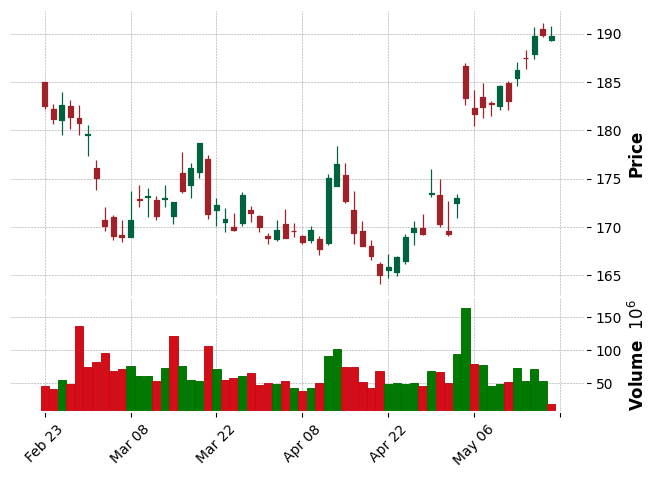

In [46]:
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame with the fetched AAPL stock data
# Make sure it contains Open, High, Low, Close, and Volume columns

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Assuming 'predicted_prices' is your list of predicted prices for the next 4 days
predictions_df = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Plotting the actual data with mplfinance
mpf.plot(data, type='candle', style='charles', volume=True)

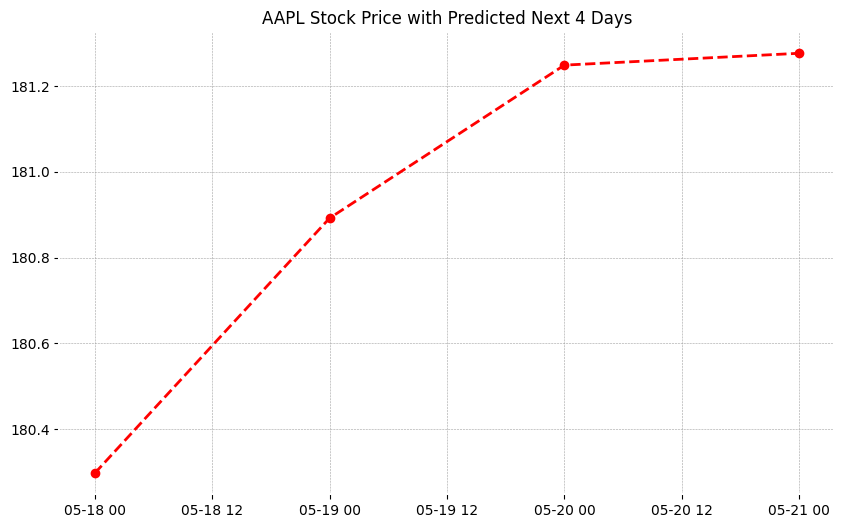

In [47]:
# Overlaying the predicted data
plt.figure(figsize=(10,6))
plt.plot(predictions_df.index, predictions_df['Close'], linestyle='dashed', marker='o', color='red')

plt.title("AAPL Stock Price with Predicted Next 4 Days")
plt.show()

- Visualization of Predictions

[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 33ms/step


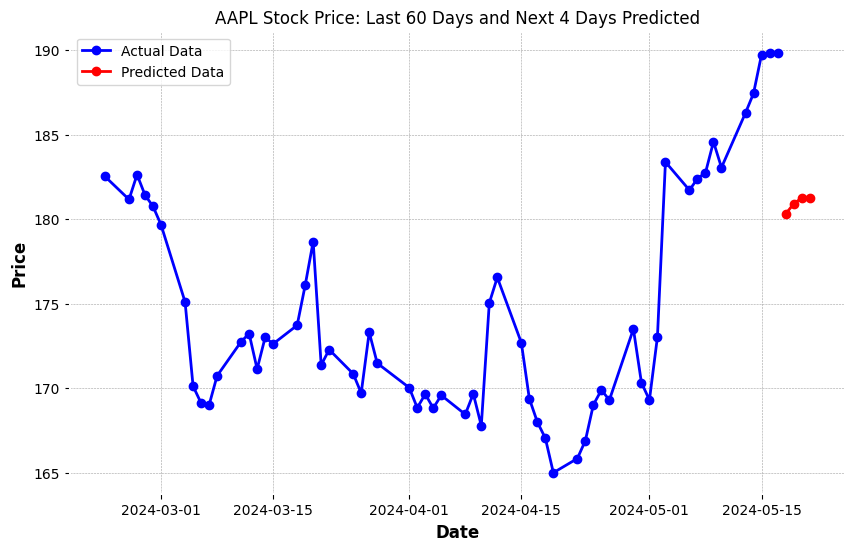

In [48]:
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Fetch the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='64d', interval='1d') # Fetch 64 days to display last 60 days in the chart

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    next_prediction = model.predict(current_batch)
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Adding predictions to the DataFrame
predicted_data = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Combining both actual and predicted data
combined_data = pd.concat([data['Close'], predicted_data['Close']])
combined_data = combined_data[-64:] # Last 60 days of actual data + 4 days of predictions

# Plotting the actual data
plt.figure(figsize=(10,6))
plt.plot(data.index[-60:], data['Close'][-60:], linestyle='-', marker='o', color='blue', label='Actual Data')

# Plotting the predicted data
plt.plot(prediction_dates, predicted_prices, linestyle='-', marker='o', color='red', label='Predicted Data')

plt.title("AAPL Stock Price: Last 60 Days and Next 4 Days Predicted")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()